In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import normal
from math import ceil

# Data

In [2]:
data_1 = pd.read_csv('data_1.csv')

In [3]:
data_1

,Frequency [MHz],Weight,a: Tsky [K],b: Tres1 [K],c: Tres2 [K],d: Tmodel [K],e: T21 [K]
0,50.012207,0,0.000000,0.000000,0.000000,0.000000,0.000000
1,50.402832,0,0.000000,0.000000,0.000000,0.000000,0.000000
2,50.793457,0,0.000000,0.000000,0.000000,0.000000,0.000000
3,51.184082,1,4645.468619,-0.034440,-0.099255,0.000000,-0.099255
4,51.574707,1,4556.501107,0.071895,0.021244,0.000000,0.021244
...,...,...,...,...,...,...,...
123,98.059082,1,877.642853,-0.169377,0.006739,-0.000103,0.006636
124,98.449707,1,868.701882,-0.181803,0.018884,-0.000068,0.018816
125,98.840332,1,859.822813,-0.259145,-0.033581,-0.000044,-0.033625
126,99.230957,0,0.000000,0.000000,0.000000,0.000000,0.000000


In [4]:
#frequency
freq = data_1.iloc[:,0]

#21cm brighness temperature
T = data_1.iloc[:,-1]

#the model represented in the paper
model = data_1.iloc[:, -2]

# Defining Some Functions

def func (x, y):
    #x is frequency
    #y is the array of paramaters
    #y[0:4] are the polynomial coef
    #y[5] is the center of frequency
    A = np.log(x/y[5])
    A_1 = (x/y[5])**(-2.5)
    A_2 = (x/y[5])**(-4.5)
    A_3 = (x/y[5])**(-2)
    return y[0] * A_1 + y[1] *A_1* A + y[2] * A_1 * (A**2) + y[3]*A_2 + y[4]*A_3

def chisquare (fobs, fexp):
    return np.sum((fobs-fexp)**2)

In [5]:
def func (x, y):
    #x is frequency
    #y is the array of paramaters
    #y[0:4] are the polynomial coef
    #v_C is the center of frequency
    v_c = 68
    A = np.log(x/v_c)
    A_1 = (x/v_c)**(-2.5)
    A_2 = (x/v_c)**(-4.5)
    A_3 = (x/v_c)**(-2)
    return y[0] * A_1 + y[1] *A_1* A + y[2] * A_1 * (A**2) + y[3]*A_2 + y[4]*A_3

def chisquare (fobs, fexp):
    return np.sum((fobs-fexp)**2)

# MCMC inputs

In [6]:
start_guess = [ 1.81434172, -4.68591817,  5.90686093, -2.02989883, -0.09532643]
nstep = 100000
out_put= func(freq, start_guess)
param_length=len(start_guess)

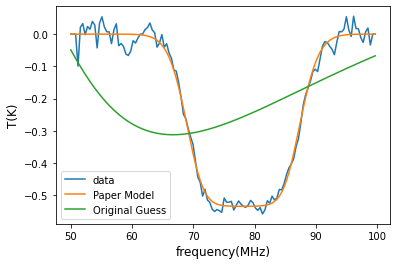

In [7]:
plt.plot(freq, T, label='data')
plt.plot(freq, model, label='Paper Model')
plt.plot(freq, out_put, label='Original Guess')
plt.xlabel('frequency(MHz)', fontsize=12)
plt.ylabel('T(K)', fontsize=12)
plt.legend()
plt.savefig('p_1')
plt.show()

# The Chain 

In [8]:
def mcmc (max_steps, start_guess):
    
    #definig the chain
    chain = np.empty((max_steps, len(start_guess)))
    chain[0, :] = start_guess
    
    #defining the chi-square
    chisq = np.empty(max_steps)
    chisq[0] = chisquare(func(freq, start_guess), T)
    
    #the chain 
    for i in range(1, max_steps):
        new_param = normal(chain[i-1], 0.005)
        new_chisq = chisquare(func(freq, new_param), T)
        
        #If chi-square gets big, we should do another step
        if new_chisq >= chisq[i-1]:
            prob = np.exp(-0.5*(new_chisq-chisq[i-1]))
            if np.random.rand() >= prob:
                chisq[i] = new_chisq
                chain[i, :] = new_param
                
            else:
                chisq[i] = chisq[i-1]
                chain[i, :] = chain[i-1, :]
                
        #if chi-square got small, we accept it        
        else:
            chisq[i] = new_chisq
            chain[i, :] = new_param
            
    return chain, chisq


In [9]:
params, cs = mcmc(nstep, start_guess)

In [10]:
mcmc_result= np.empty(param_length)

for i in range(param_length):
    mcmc_result[i] = np.mean(params[:,i])
    
out_put_mcmc = func(freq, mcmc_result)

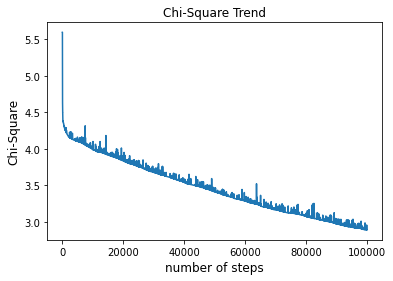

In [11]:
plt.plot(cs)
plt.xlabel('number of steps', fontsize=12)
plt.title ('Chi-Square Trend', fontsize=12)
plt.ylabel('Chi-Square', fontsize=12)
plt.savefig('p_2')
plt.show()

5


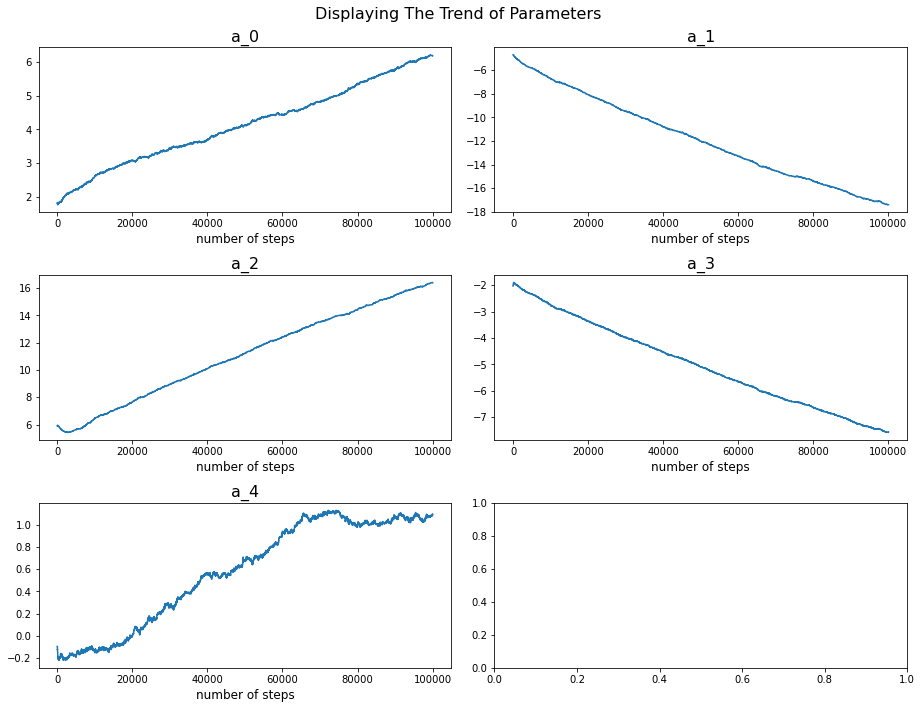

In [12]:
fig, ax_list = plt.subplots(ceil(param_length/2), 2, figsize=(13,10))
fig.suptitle('Displaying The Trend of Parameters', fontsize=16)
print(param_length)
if((param_length % 2) == 0):
    for i in range(ceil(param_length/2)):
        for j in range(2):
            #print(i)
            #print (j)
            ax_list[i, j].plot(params[:, i*2+ j])
            ax_list[i, j].set_title(f'a_{i*2+ j}', fontsize=16)
            ax_list[i, j].set_xlabel('number of steps', fontsize=12)

else:
    for i in range(ceil(param_length/2)):
        for j in range(2):
            if(j == 1 and i == (ceil(param_length/2)-1)):
                break
            #print(i)
            #print (j)
            ax_list[i, j].plot(params[:, i*2+ j])
            ax_list[i, j].set_title(f'a_{i*2+ j}', fontsize=16)
            ax_list[i, j].set_xlabel('number of steps', fontsize=12)
            

plt.tight_layout()
plt.savefig('_3')
plt.show()       

In [13]:
for i in range(len(start_guess)):
    print(f'Parameters : a_{i}= ', mcmc_result[i])

print("Chi squared of mcmc:",chisquare(func(freq, mcmc_result),T))
print("Chi squared of original guess:",chisquare(func(freq,start_guess),T))

Parameters : a_0=  4.14088736694802
Parameters : a_1=  -11.783092706437719
Parameters : a_2=  11.097524415258366
Parameters : a_3=  -5.008223992764138
Parameters : a_4=  0.5797191508925829
Chi squared of mcmc: 3.430601429207786
Chi squared of original guess: 5.594485517552055


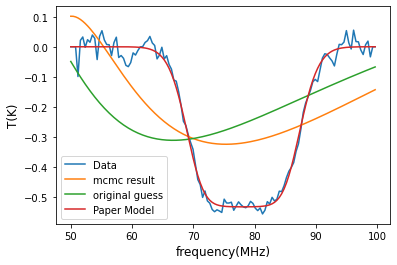

In [14]:
fig2 = plt.figure()
plt.plot(freq, T, label='Data')
plt.plot(freq, out_put_mcmc, label="mcmc result")
plt.plot(freq, out_put, label= "original guess")
plt.plot(freq, model, label= 'Paper Model')
plt.legend()
plt.xlabel('frequency(MHz)', fontsize=12)
plt.ylabel('T(K)', fontsize=12)
plt.savefig('p_4')
#plt.ylim(top=-0.4)
#plt.xlim(65,90)
plt.show()

# Residuals

In [15]:
r_paper_model = out_put_mcmc - model
r_data = out_put_mcmc - T

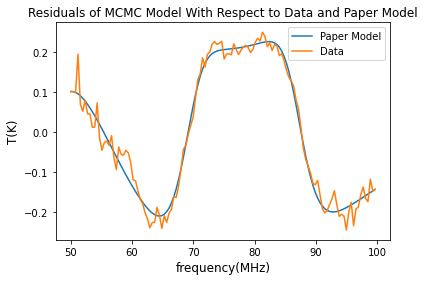

In [16]:
plt.plot(freq, r_paper_model, label= 'Paper Model')
plt.plot(freq, r_data, label= 'Data')
plt.legend()
plt.xlabel('frequency(MHz)', fontsize=12)
plt.ylabel('T(K)', fontsize=12)
plt.title('Residuals of MCMC Model With Respect to Data and Paper Model')
#plt.ylim(top=-0.4)
#plt.xlim(65,90)
plt.savefig('p_5')
plt.show()